# Section 5.2 — Bayesian inference computations

This notebook contains the code examples from [Section 5.2 Bayesian inference computations]() from the **No Bullshit Guide to Statistics**.

See also:

- [Chp_04.ipynb](./explorations/SR2024/week02/Chp_04.ipynb)
- [Chp_05.ipynb](./explorations/SR2024/week02/Chp_05.ipynb)
- [homework_week02_ivan_savov.ipynb](./explorations/SR2024/week02/homework_week02_ivan_savov.ipynb)

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/computations"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Example 1: estimating the probability of a biased coin

In [4]:
# Sample of coin tosses observations (1=heads 0=tails)
# We assume they come from a Bernoulli distribution
ctosses = [1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,
           1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,
           0,1,0,1,0,1,0,1,1,0]
sum(ctosses), len(ctosses), sum(ctosses)/len(ctosses)

(34, 50, 0.68)

In [5]:
df1 = pd.DataFrame({"heads":ctosses})
df1.head()

,heads
0,1
1,1
2,0
3,0
4,1


In [6]:
# ALT. load the `ctosses` data frame from the exercises/ folder
df1 = pd.read_csv("../datasets/exercises/ctosses.csv")
df1.head()

,heads
0,1
1,1
2,0
3,0
4,1


In [7]:
df1["heads"].mean()

0.68

The model is

$$
    C \sim \textrm{Bernoulli}(p)
    \qquad
    p \sim \mathcal{U}(0,1).
$$

In [8]:
# BONUS DEMO: simulate a random sample from the data model (for a fixed `true_p`)
# np.random.seed(46)

# params
n = len(ctosses)
true_p = 0.7

# gen a random dataframe DF1 like df1
from scipy.stats import bernoulli
ctosses = bernoulli(p=true_p).rvs(n)
DF1 = pd.DataFrame({"heads": ctosses})
DF1["heads"].values, DF1["heads"].mean()

(array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1]),
 0.78)

In [9]:
# BONUS DEMO: simulate a random sample from the full Bayesian model
# np.random.seed(47)
n = len(ctosses)

# gen parameters p independently for each observation
from scipy.stats import uniform
true_ps = uniform(0,1).rvs(n)

# gen a random data sample of size n
from scipy.stats import bernoulli
ctosses = bernoulli(p=true_ps).rvs(n)
DF1 = pd.DataFrame({"ctoss": ctosses})
DF1["ctoss"].values, DF1["ctoss"].mean()

(array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0]),
 0.46)

In [10]:
import bambi as bmb

formula = "heads ~ 1"

priors1 = {
    "Intercept": bmb.Prior("Uniform", lower=0, upper=1),
    # "Intercept": bmb.Prior("Beta", alpha=1, beta=1),
}

#######################################################
mod1 = bmb.Model(formula,
                 priors=priors1,
                 family="bernoulli",
                 link="identity",
                 data=df1)
mod1.set_alias({"Intercept":"p prior"})
mod1

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       Formula: heads ~ 1
        Family: bernoulli
          Link: p = identity
  Observations: 50
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Uniform(lower: 0.0, upper: 1.0)

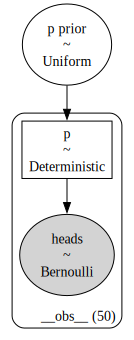

In [11]:
mod1.build()
mod1.graph()

In [12]:
idata1 = mod1.fit(draws=2000)

Modeling the probability that heads==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p prior]
/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/pytensor/scalar/basic.py:3056: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/pytensor/scalar/basic.py:3056: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in i

Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [13]:
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [14]:
import arviz as az
az.summary(idata1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
p prior,0.674,0.064,0.554,0.792


In [15]:
az.summary(idata1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p prior,0.674,0.064,0.554,0.792,0.001,0.001,3491.0,5335.0,1.0


In [16]:
az.plot_posterior(idata1, var_names="Intercept", point_estimate="mode", hdi_prob=0.9);

KeyError: 'var names: "[\'Intercept\'] are not present" in dataset'

In [ ]:
# ALT. manual plot of posterior density
post = az.extract(idata1, group="posterior", var_names="Intercept").values
sns.kdeplot(x=post.flatten(), bw_adjust=1);

In [ ]:
# BONUS: verify the prior was flat
# mod1.plot_priors();

In [ ]:
# mod1.predict(idata1, kind="response")
# preds = az.extract(idata1, group="posterior_predictive", var_names="win").values
# sns.histplot(x=preds.sum(axis=0), stat="density")
# sns.kdeplot(x=post.mean(axis=0)*30)

### ALT. Declare a model in PyMC

In [ ]:
import pymc as pm

with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    p = pm.Beta("p", alpha=1, beta=1)
    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=p, observed=df1)
    # Sample from the posterior distribution
    idata1_alt = pm.sample(draws=2000)

In [ ]:
az.summary(idata1_alt, kind="stats")

In [ ]:
pred_dists1 = (pm.sample_prior_predictive(1000, model).prior_predictive["y_obs"].values,
              pm.sample_posterior_predictive(idata1, model).posterior_predictive["y_obs"].values)

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists1):
    az.plot_dist(dist.sum(-1), 
                 hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                 ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution", fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_xlabel("number of success")

az.plot_dist(pm.draw(p, 1000),
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("p")

az.plot_dist(idata1.posterior["Intercept"],
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1},
             ax=axes[2])
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("p");

In [ ]:
# ???
# from scipy.stats import binom
# predictions1 = (binom(n=1, p=idata1.posterior["Intercept"].mean()).rvs((4000, len(ctosses))),
#                pred_dists1[1])
# for d, c, l in zip(predictions, ("C0", "C4"), ("posterior mean", "posterior predictive")):
#     ax = az.plot_dist(d.sum(-1),
#                       label=l,
#                       figsize=(10, 5),
#                       hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
#     ax.set_yticks([])
#     ax.set_xlabel("number of success")

## Example 2: estimating the IQ score

In [ ]:
# Sample of IQ observations
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

We assume the IQ scores come from a population with standard deviation $\sigma = 15$.

In [ ]:
df2 = pd.DataFrame({"iq":iqs})
# df2.head()
np.mean(iqs)

In [ ]:
# ALT. load the `iqs.csv` data file from the exercises/ folder
df2 = pd.read_csv("../datasets/exercises/iqs.csv")
# df2.head()
df2["iq"].mean()

The model is

$$
    X \sim \mathcal{N}(M, \sigma=15)
    \qquad
    M \sim \mathcal{N}(\mu_M=100,\sigma_M=40).
$$

In [ ]:
#######################################################

In [ ]:
import bambi as bmb
import pymc as pm

formula2 = "iq ~ 1"

priors2 = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=40),
    # "sigma": bmb.Prior("Normal", mu=15, sigma=0.01), # hack to get constant value
    # "sigma": bmb.Prior("Deterministic", var=pm.ConstantData("sigma", value=15)),
    # pm.ConstantData
    "sigma": bmb.Prior("ConstantData", value=15),
}

mod2 = bmb.Model(formula2,
                 priors=priors2,
                 family="gaussian",
                 link="identity",
                 data=df2)

mod2.set_alias({"Intercept":"mu prior"})
mod2

In [ ]:
mod2.build()
mod2.graph()

In [ ]:
idata2 = mod2.fit(draws=2000)
# idata2

In [ ]:
az.plot_posterior(idata2, var_names="Intercept", point_estimate="mode", hdi_prob=0.9);

In [ ]:
import arviz as az
az.summary(idata2, kind="stats")

In [ ]:
az.summary(idata2, kind="stats", stat_focus="median")

In [ ]:
mod2.backend.model.data_vars

In [ ]:
mod2.backend.model.observed_RVs

In [ ]:
mod2.backend.model.unobserved_RVs

## Discussion

### MCMC diagnostic plots

There are several Arviz plots we can use to check if the Markov Chain Monte Carlo chains were sampling from the posterior as expected, or ...

In [ ]:
# az.plot_trace(idata);
# az.plot_trace(idata, kind="rank_bars");
# az.plot_trace(idata, kind="rank_vlines");

# plot_cap ~= partial regression plots?
# e.g. plot_cap(model_2, fitted_2, "weight", ax=ax);

### Choice of priors

Different priors lead to different posteriors.

See `Code 1.8 and Figure 1.7` in
[chp_01.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_01.ipynb)

In [ ]:
from scipy.stats import beta

x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys",
          "MaxEnt",
          "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}", lw=3)
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()
# plt.savefig("img/chp01/prior_informativeness_spectrum.png")

### Bayesian workflow

See also [chp_09.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_09.ipynb)